In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from service.app_api.features.extractor import FeatureExtractor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from yellowbrick.cluster.elbow import KElbowVisualizer
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from scipy.stats.mstats import winsorize

/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keywo

In [2]:
# customers, sales = pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_customers'), pd.read_excel('ucy_eko_data.xlsx', sheet_name='smile_sales')
customers, sales = joblib.load('customers.joblib'), joblib.load('sales.joblib')

In [3]:
fe = FeatureExtractor(target_month=3, perform_split=False, period=60, subperiod=60, generation_type='continuous', filtering_set='sales')
X, y = fe.transform(sales=sales, customers=customers)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/fedorturchenko/.cache/huggingface/token
Login successful
Successfully logged out.


In [8]:
s = 'fuel_qty_1-60'
s[:s.find('_1-60')]

'fuel_qty'

In [5]:
X.columns = [f'{col[:col.find("_1-60")]}' for col in X.columns]
X.head()

,fuel_qty,labour_cards_catalogue_consumables_qty,peak_hours_qty,usual_hours_qty,weekday_qty,weekend_qty,unleaded_95_qty,average_days_between_visits,recency,monetary,last_purchase_qty_share,labour_cards_catalogue_consumables,full_non_fuel_purchase
0,7.78,0.0,11.78,0.00,11.78,0.00,7.78,0.000000,60,11.78,1.000000,0,0
1,233.60,0.0,39.13,195.47,136.16,98.44,39.13,5.571429,18,234.60,0.201662,0,0
2,225.50,0.0,0.00,225.50,225.50,0.00,113.29,9.000000,32,225.50,0.317916,0,0
3,695.23,0.0,60.00,639.23,597.60,101.63,30.65,3.923077,1,699.23,0.029676,0,0
4,131.77,0.0,0.00,131.77,131.77,0.00,131.77,5.222222,9,131.77,0.126964,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


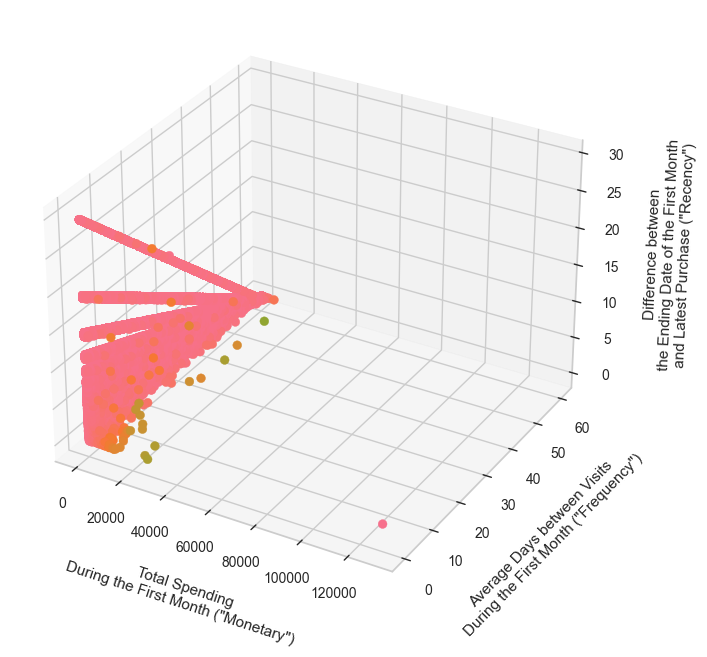

In [7]:
# X_clust = X[X['monetary']<=1000][['monetary', 'recency', 'average_days_between_visits']]

X_clust = X[['monetary', 'recency', 'average_days_between_visits']]

fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette('husl', 256).as_hex())

sc = ax.scatter(X_clust['monetary'], X_clust['recency'], X_clust['average_days_between_visits'], s=40, c=X_clust['monetary'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Total Spending\nDuring the First Month ("Monetary")', labelpad=20)
ax.set_ylabel('Average Days between Visits\nDuring the First Month ("Frequency")', labelpad=20)
ax.set_zlabel('Difference between\nthe Ending Date of the First Month\nand Latest Purchase ("Recency")', labelpad=20)

ax.legend()
fig.show()

Plot shows extreme outliers for the Monetary variable. Let us examine 99th percentile of this variable

In [25]:
print(f"99th percentile: {X_clust['monetary'].quantile(0.99)}")
print(f"Maximum: {X_clust['monetary'].max()}")

99th percentile: 1251.965199999999
Maximum: 129450.0


Since the 99th percentile differs from the maximum value, it makes sense to winsorize these outliers

In [8]:
winsor = winsorize(X['monetary'], limits=(0.0, 0.01))
with open('service/app_api/features/winsorizing_object_for_threshold.pkl', 'wb') as f:
    pickle.dump(winsor, f)
X_clust['monetary'] = winsor
X_clust['monetary'].max()

1252.36

Let us now examine the plot again

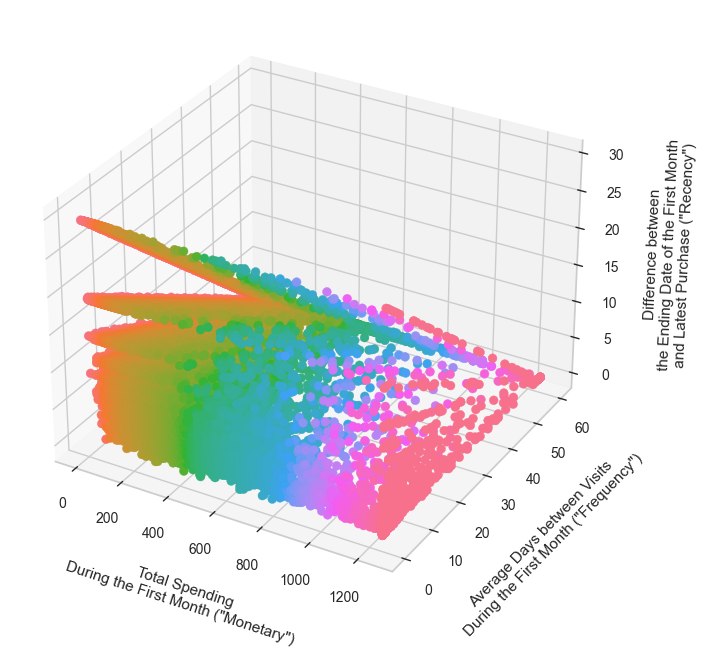

In [27]:
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

sc = ax.scatter(X_clust['monetary'], X_clust['recency'], X_clust['average_days_between_visits'], s=40, c=X_clust['monetary'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('Total Spending\nDuring the First Month ("Monetary")', labelpad=20)
ax.set_ylabel('Average Days between Visits\nDuring the First Month ("Frequency")', labelpad=20)
ax.set_zlabel('Difference between\nthe Ending Date of the First Month\nand Latest Purchase ("Recency")', labelpad=20)

fig.show()

Examining the plot, one may consider that 3 or 4 clusters could be optimal

In [9]:
X_clust = StandardScaler().fit_transform(X_clust)
model = KMeans()
elbow_viz = KElbowVisualizer(model, k=(1, 11))

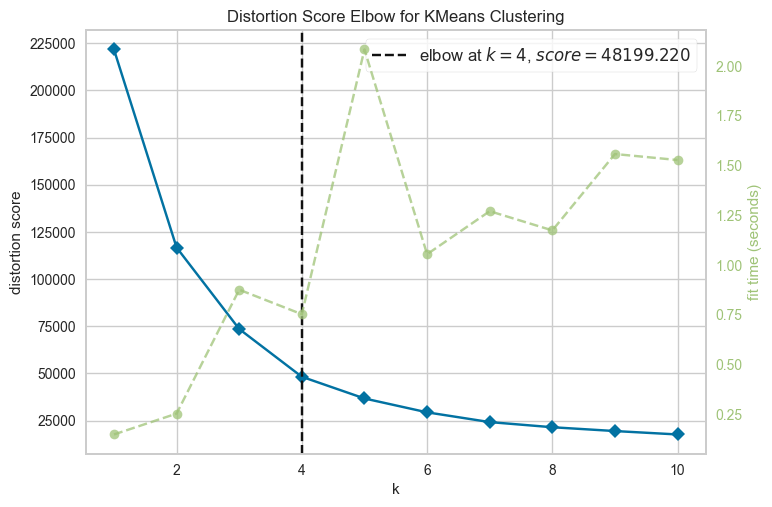

In [19]:
elbow_viz.fit(X_clust)
elbow_viz.show()

Elbow method suggests 4 clusters as the optimal value. Let us also compute silhoutte ccore:

In [16]:
for k in range(2, 11):
    model = KMeans(k)
    labels = model.fit_predict(X_clust)
    print(f'{k}: {silhouette_score(X_clust, labels)}')

2: 0.5142505689024423
3: 0.5454003924759869
4: 0.5157959481173936
5: 0.48516634402145903
6: 0.4974689840177214
7: 0.48857966107510703
8: 0.46778527892316646
9: 0.4642974922857461
10: 0.4609785028415993


The best silhoutte score was also computed for 4 clusters

In [10]:
K = 4
best_model = KMeans(n_clusters=K, random_state=571)
labels = best_model.fit_predict(X_clust)
centroids = best_model.cluster_centers_

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

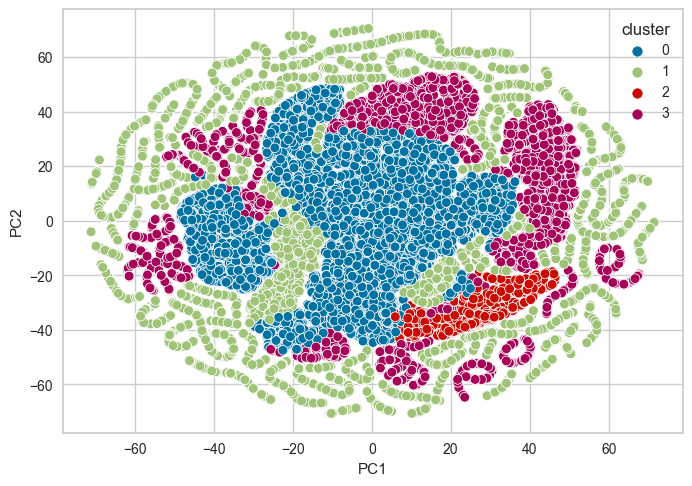

In [18]:
fig, ax = plt.subplots()

tsne = TSNE(n_components=2, random_state=0)
df_clust = pd.DataFrame(tsne.fit_transform(X_clust), columns=['PC1','PC2'])
df_clust['cluster'] = pd.Categorical(labels)

sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_clust, ax=ax)

In [11]:
X['cluster'] = pd.Categorical(labels).rename_categories(
    {
        0: 'Regular drivers',
        1: 'Passerbys',
        2: 'Frequent drivers',
        3: 'At Churn Risk'
    }
)
X['cluster'].value_counts().sort_index()

Regular drivers     28265
Passerbys           26526
Frequent drivers     3148
At Churn Risk       15956
Name: cluster, dtype: int64

In [76]:
X['target'] = pd.Categorical(y).rename_categories(
    {
        0: 'No purchases at month 3',
        1: 'At least 2 purchases at month 3'
    }
)

In [12]:
X = X.rename({'average_days_between_visits': 'frequency'}, axis=1)

In [142]:
X_agg = X.pivot_table(values=['monetary', 'recency', 'frequency'], columns=['target', 'cluster'], aggfunc=np.median).round(2)
X_agg = X_agg.rename({i: i.capitalize() for i in X_agg.index.unique()}, axis=0)
X_agg.columns.names = ['', 'Indicator']

In [128]:
new_cols = []
for i, j in X_agg.columns:
    if j == 'Regular drivers':
        new_cols.append(f"{i}\n{j}")
    else:
        new_cols.append(j)
X_agg.columns = new_cols

In [143]:
X_agg

No purchases at month 3                                           \
Indicator         Regular drivers Passerbys Frequent drivers At Churn Risk   
Frequency                    7.57      0.00              3.7         14.50   
Monetary                   175.36     36.31            856.6         79.95   
Recency                     11.00     60.00             15.0         13.00   

          At least 2 purchases at month 3                             \
Indicator                 Regular drivers Passerbys Frequent drivers   
Frequency                            5.86      1.38             2.43   
Monetary                           236.13     47.51           797.48   
Recency                              4.00     56.00             2.00   

                         
Indicator At Churn Risk  
Frequency         14.00  
Monetary          93.44  
Recency            8.00

In [201]:
X_agg_json = {}
for col_0 in X_agg.columns.get_level_values(0).unique():
    X_agg_json[col_0] = [(X_agg[col_0].to_dict(orient='dict'))]

In [202]:
X_agg_json

{'No purchases at month 3': [{'Regular drivers': {'Frequency': 7.57,
    'Monetary': 175.36,
    'Recency': 11.0},
   'Passerbys': {'Frequency': 0.0, 'Monetary': 36.31, 'Recency': 60.0},
   'Frequent drivers': {'Frequency': 3.7, 'Monetary': 856.6, 'Recency': 15.0},
   'At Churn Risk': {'Frequency': 14.5, 'Monetary': 79.95, 'Recency': 13.0}}],
 'At least 2 purchases at month 3': [{'Regular drivers': {'Frequency': 5.86,
    'Monetary': 236.13,
    'Recency': 4.0},
   'Passerbys': {'Frequency': 1.38, 'Monetary': 47.51, 'Recency': 56.0},
   'Frequent drivers': {'Frequency': 2.43, 'Monetary': 797.48, 'Recency': 2.0},
   'At Churn Risk': {'Frequency': 14.0, 'Monetary': 93.44, 'Recency': 8.0}}]}

In [203]:
import json

with open('service/app_ui/shap_plots/segments_target_rfm_table.json', 'w') as f:
    json.dump(X_agg_json, f)

In [206]:
with open('service/app_ui/shap_plots/segments_target_rfm_table.json') as data_file:    
    d = json.load(data_file)  
df = pd.concat({k: pd.DataFrame(v) for k, v in d.items()}).unstack(0).swaplevel(1,0, axis=1).sort_index(axis=1)
df

At least 2 purchases at month 3  \
                                       At Churn Risk   
0  {'Frequency': 14.0, 'Monetary': 93.44, 'Recenc...   

                                                      \
                                    Frequent drivers   
0  {'Frequency': 2.43, 'Monetary': 797.48, 'Recen...   

                                                      \
                                           Passerbys   
0  {'Frequency': 1.38, 'Monetary': 47.51, 'Recenc...   

                                                      \
                                     Regular drivers   
0  {'Frequency': 5.86, 'Monetary': 236.13, 'Recen...   

                             No purchases at month 3  \
                                       At Churn Risk   
0  {'Frequency': 14.5, 'Monetary': 79.95, 'Recenc...   

                                                      \
                                    Frequent drivers   
0  {'Frequency': 3.7, 'Monetary': 856.6, 'Recency...   

                                                      \
                                           Passerbys   
0  {'Frequency': 0.0, 'Monetary': 36.31, 'Recency...   

                                                      
                                     Regular drivers  
0  {'Frequency': 7.57, 'Monetary': 175.36, 'Recen...

In [15]:
X.groupby('cluster').agg(
    Recency = pd.NamedAgg('recency', 'median'),
    Frequency = pd.NamedAgg('frequency', 'median'),
    Monetary = pd.NamedAgg('monetary', 'median')
)

,Recency,Frequency,Monetary
cluster,,,
Regular drivers,7.0,6.666667,204.260
Passerbys,60.0,0.000000,36.530
Frequent drivers,3.0,2.631579,816.425
At Churn Risk,12.0,14.500000,82.250


- Regular drivers:
    - medium spending
    - medium recency
    - medium frequency

This cluster customers are quite loyal but, perhaps, not driving this much, so they do not need to visit gas stations often and pay much

- Passerbys:
    - lowest spending
    - worst recency
    - zero frequency

This cluster represents users who made one-two visits and most likely left

- Frequent drivers:
    - highest spending
    - best recency
    - best frequency

This cluster represents users who are frequently visiting gas stations, paying a lot. Perhaps, these are the most loyal customers who are driving long distances

- At churn risk:
    - low spending
    - medium recency
    - low frequency

This cluster represents users who are visiting gas stations from time to time. They are not spending much, not making their visits often, so could be considered to be at risk of churn

In [69]:
# X_agg.columns.get_level_values(0).replace()
X_agg.columns.get_level_values(1).rename_categories(
    {
        0: 'Regular drivers',
        1: 'Passerbys',
        2: 'Frequent drivers',
        3: 'At Churn Risk'
    }
)

CategoricalIndex(['Regular drivers', 'Passerbys', 'Frequent drivers',
                  'At Churn Risk', 'Regular drivers', 'Passerbys',
                  'Frequent drivers', 'At Churn Risk'],
                 categories=['Regular drivers', 'Passerbys', 'Frequent drivers', 'At Churn Risk'], ordered=False, dtype='category', name='cluster')

In [24]:
import pickle
with open('./features/clustering_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [25]:
pd.Series(best_model.labels_).value_counts()

0    28265
1    26526
3    15956
2     3148
dtype: int64

In [309]:
with open('service/app_api/features/clustering_model.pkl', 'rb') as f:
            model = pickle.load(f)
        # Load `scipy.stats.mstats.winsorize` output object to define threshold for the `monetary` variable
with open('service/app_api/features/winsorizing_object_for_threshold.pkl', 'rb') as f:
    winsor = pickle.load(f)
X_clust = X[['monetary', 'recency', 'average_days_between_visits']]
monetary_threshold = winsor.max()
# Perform winsorization
X_clust.loc[X_clust['monetary'] > monetary_threshold, 'monetary'] = monetary_threshold
scaler = StandardScaler()
labels = pd.Categorical(
    model.predict(
        scaler.fit_transform(X_clust)
    )
)
X['segments'] = labels
X['segments'] = X['segments'].cat.rename_categories({3: 'at_churn_risk', 2: 'frequent_drivers', 1: 'passerbys', 0: 'regular_drivers'})

In [29]:
X['segments'].value_counts()

regular_drivers     28265
passerbys           26526
at_churn_risk       15956
frequent_drivers     3148
Name: segments, dtype: int64

In [150]:
import random
from scipy.spatial.distance import cdist

sample = X.loc[random.randint(0, X.index.max()), ['average_days_between_visits', 'recency', 'monetary']]
dist = cdist(np.array(sample, ndmin=2), centroids, 'cosine')[0]
sim = 1-dist
label = labels[sample.name]
print(label)
print(dist)
print(sim)

1
[1.7716814  0.63259364 1.23554206 0.80489905]
[-0.7716814   0.36740636 -0.23554206  0.19510095]


In [151]:
(sim+1)/2

array([0.1141593 , 0.68370318, 0.38222897, 0.59755048])

In [156]:
import wandb
from service.app_api.configs import utils, settings
utils.login_wandb()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Appending key for api.wandb.ai to your netrc file: /Users/fedorturchenko/.netrc


In [330]:
# wandb.sklearn.plot_elbow_curve(best_model, X_clust)
with utils.init_wandb_run(
    name='rfm_features_clustering',
    model=KMeans,
    config=best_model.get_params(),
    target_month=None,
    group='clustering',
    job_type='clustering_fit'
) as run:
    metadata = {
        'experiment': {
            'name': run.name,
        }
    }
    artifact = wandb.Artifact(
        name='clustering_report',
        type='performance_metric',
        metadata=metadata
    )
    artifact.add(wandb.Table(data=centroids, columns=['monetary', 'recency', 'average_days_between_visits']), name='centroids_table')
    artifact.add(wandb.Table(columns=['monetary_winsorization_threshold'], data=[[monetary_threshold]]), name='monetary_winsorization_threshold')
    run.log_artifact(artifact)
    run.finish()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [331]:
cm = utils.get_artifact('K-Means', 'clustering_report')
cm.download('service/app_api/configs/')

wandb:   2 of 2 files downloaded.  


'service/app_api/configs/'

In [29]:
import json

with open('service/app_api/configs/centroids_table.table.json', 'r') as f:
    table = json.load(f)

In [306]:
s = np.array(sample, ndmin=2)

In [332]:
s[s[0][table['columns'].index('monetary')] > monetary_threshold] = monetary_threshold

In [333]:
s = StandardScaler().fit_transform(s)

In [337]:
sim = np.exp(-cdist(s, table['data'], 'euclidean'))

In [341]:
sim[0].tolist().index(sim.max())

0

In [227]:
labels_euc = []
euc_dist_matrix = cdist(X_clust, centroids, 'euclidean')
for row in euc_dist_matrix:
    max_dist = row.min()
    pred = row.tolist().index(max_dist)
    labels_euc.append(pred)

In [228]:
pd.Series(labels == np.array(labels_euc)).value_counts(normalize=True)

True    1.0
dtype: float64

In [245]:
euc_dist_df = pd.DataFrame(euc_dist_matrix)
euc_dist_df.head()

,0,1,2,3
0,2.623197,0.332707,4.982150,3.229837
1,0.386474,1.993860,3.349170,1.819418
2,1.006884,1.828062,3.594751,1.505668
3,2.465545,4.063452,1.029070,3.678803
4,0.536491,2.145161,3.844673,1.744337


In [255]:
euc_dist_df.apply(lambda x: np.exp(-x), axis=0).head()#.describe()

,0,1,2,3
0,0.072571,0.716980,0.006859,0.039564
1,0.679448,0.136169,0.035113,0.162120
2,0.365356,0.160725,0.027468,0.221869
3,0.084963,0.017190,0.357339,0.025253
4,0.584797,0.117049,0.021393,0.174761


In [30]:
cm = utils.get_artifact('K-Means', f"clustering_report")

NameError: name 'utils' is not defined

In [272]:
cm.get('centroids')